In [1]:
import os
import glob
import random

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nrrd
import matplotlib.pyplot as plt

import torchio as tio

In [2]:
path_segmentation = os.path.join(os.getcwd(), '..', 'data', 'segmentation')

In [3]:
data = []

n_files = 103

for i in tqdm(range(1, n_files)):
    
    path_image = os.path.join(path_segmentation, f'{i}.nrrd')
    path_mask = os.path.join(path_segmentation, f'{i}_Segmentation.nrrd')
    
    image, header = nrrd.read(path_image)
    
    if os.path.isfile(path_mask):
        
        mask, header = nrrd.read(path_mask)
        
        try:
            assert image.shape == mask.shape
        except AssertionError:
            print(i, image.shape, mask.shape)
    else:
        mask = None
            
    data.append({
        'image': path_image.split(os.sep)[-1],
        'image_slices': image.shape[0],
        'image_height': image.shape[1],
        'image_width': image.shape[2],
        'mask': path_mask.split(os.sep)[-1] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_slices': mask.shape[0] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_height': mask.shape[1] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_width': mask.shape[2] if isinstance(mask, np.ndarray) else pd.NaT,
        'slices_positive': (mask > 0).any(axis=(1, 2)).sum() if isinstance(mask, np.ndarray) else pd.NaT,
        'positive_pixels_ratio': mask[mask == 1].sum() / len(mask.flatten()) if mask is not None else pd.NaT
    })
    
df = pd.DataFrame(data)

df['positive_ratio'] = df['slices_positive'] / df['image_slices']
condition = df['positive_ratio'].notnull()
df.loc[condition, 'positive_slice_ratio'] = df.loc[condition, 'positive_ratio'].apply(lambda x: f'{x:.2f} %')


  0%|          | 0/102 [00:00<?, ?it/s]

In [5]:
df

,image,image_slices,image_height,image_width,mask,mask_slices,mask_height,mask_width,slices_positive,positive_pixels_ratio,positive_ratio,positive_slice_ratio
0,1.nrrd,62,64,64,1_Segmentation.nrrd,62,64,64,11,0.002788,0.177419,0.18 %
1,2.nrrd,64,64,64,2_Segmentation.nrrd,64,64,64,8,0.001518,0.125,0.12 %
2,3.nrrd,64,64,64,3_Segmentation.nrrd,64,64,64,18,0.008568,0.28125,0.28 %
3,4.nrrd,64,64,64,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
4,5.nrrd,128,128,128,5_Segmentation.nrrd,128,128,128,22,0.001923,0.171875,0.17 %
...,...,...,...,...,...,...,...,...,...,...,...,...
97,98.nrrd,52,128,128,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
98,99.nrrd,28,64,64,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
99,100.nrrd,52,128,128,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN
100,101.nrrd,83,128,128,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN


In [11]:
print(f"Mean volume depth: {df['image_slices'].mean():.4f}")
print(f"Min. volume depth: {df['image_slices'].min()}")
print(f"Max. volume depth: {df['image_slices'].max()}")

Mean volume depth: 55.8039
Min. volume depth: 17
Max. volume depth: 128


In [12]:
df_labeled = df.loc[df['slices_positive'].notnull()].sort_values('slices_positive').reset_index(drop=True)

In [13]:
df_labeled

,image,image_slices,image_height,image_width,mask,mask_slices,mask_height,mask_width,slices_positive,positive_pixels_ratio,positive_ratio,positive_slice_ratio
0,2.nrrd,64,64,64,2_Segmentation.nrrd,64,64,64,8,0.001518,0.125,0.12 %
1,11.nrrd,64,64,64,11_Segmentation.nrrd,64,64,64,10,0.003124,0.15625,0.16 %
2,1.nrrd,62,64,64,1_Segmentation.nrrd,62,64,64,11,0.002788,0.177419,0.18 %
3,6.nrrd,64,64,64,6_Segmentation.nrrd,64,64,64,11,0.006325,0.171875,0.17 %
4,8.nrrd,17,64,64,8_Segmentation.nrrd,17,64,64,11,0.012624,0.647059,0.65 %
5,10.nrrd,52,128,128,10_Segmentation.nrrd,52,128,128,12,0.0036,0.230769,0.23 %
6,7.nrrd,24,64,64,7_Segmentation.nrrd,24,64,64,13,0.027384,0.541667,0.54 %
7,3.nrrd,64,64,64,3_Segmentation.nrrd,64,64,64,18,0.008568,0.28125,0.28 %
8,9.nrrd,128,128,52,9_Segmentation.nrrd,128,128,52,19,0.003933,0.148438,0.15 %
9,5.nrrd,128,128,128,5_Segmentation.nrrd,128,128,128,22,0.001923,0.171875,0.17 %


In [18]:
print(f"Mean positive slice ratio: {df_labeled['positive_ratio'].mean():.4f}")
print(f"Min. positive slice ratio: {df_labeled['positive_ratio'].min():.4f}")
print(f"Max. positive slice ratio: {df_labeled['positive_ratio'].max():.4f}")

Mean positive slice ratio: 0.2652
Min. positive slice ratio: 0.1250
Max. positive slice ratio: 0.6471


In [19]:
print(f"Mean positive pixels ratio: {df_labeled['positive_pixels_ratio'].mean():.4f}")
print(f"Min. positive pixels ratio: {df_labeled['positive_pixels_ratio'].min():.4f}")
print(f"Max. positive pixels ratio: {df_labeled['positive_pixels_ratio'].max():.4f}")

Mean positive pixels ratio: 0.0072
Min. positive pixels ratio: 0.0015
Max. positive pixels ratio: 0.0274


In [6]:
df['image_width'].value_counts()

64     61
128    39
52      1
80      1
Name: image_width, dtype: int64

In [7]:
df['image_height'].value_counts()

64     61
128    40
80      1
Name: image_height, dtype: int64

In [8]:
df['image_slices'].value_counts().sort_index()

17      1
21      1
22      1
24      1
26     15
27      2
28      3
29      4
33      1
47      1
52     15
54      5
56      2
58      4
60      1
62      2
64     32
71      1
80      1
83      1
128     8
Name: image_slices, dtype: int64

In [9]:
df.loc[(df['slices_positive'].notnull()), 'slices_positive'].value_counts()

11    3
8     1
18    1
22    1
13    1
19    1
12    1
10    1
Name: slices_positive, dtype: int64

## For TorchIO create dataset with axes order C x W x H x D

In [4]:
path_xyz = os.path.join(os.getcwd(), '..', 'data', 'segmentation_xyz')

if not os.path.isdir(path_xyz):
    os.mkdir(path_xyz)

In [11]:
files = list(df[['image', 'mask']].to_records(index=False))

for file_image, file_mask in tqdm(files):
    
    image, head = nrrd.read(os.path.join(path_segmentation, file_image))
    image = np.expand_dims(image.swapaxes(0, 1).swapaxes(1, 2), axis=0)
    
    resize = tio.Resize((128, 128, image.shape[2]), image_interpolation='linear')
    image = np.squeeze(resize(image), axis=0)
    
    nrrd.write(os.path.join(path_xyz, file_image), image)
    
    if not pd.isnull(file_mask):
        
        mask, head = nrrd.read(os.path.join(path_segmentation, file_mask))
        mask = np.expand_dims(mask.swapaxes(0, 1).swapaxes(1, 2), axis=0)
        mask = np.squeeze(resize(mask), axis=0)
        nrrd.write(os.path.join(path_xyz, file_mask), mask)

  0%|          | 0/102 [00:00<?, ?it/s]

In [109]:
for i, (file_image, file_mask) in enumerate(tqdm(files)):
    
    image, head = nrrd.read(os.path.join(path_xyz, file_image))
    mask, head = nrrd.read(os.path.join(path_xyz, file_mask))
    
    break

  0%|          | 0/102 [00:00<?, ?it/s]

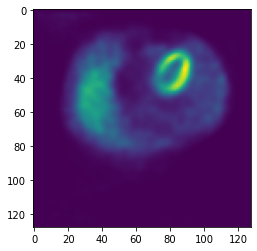

In [110]:
plt.imshow(image[..., 26])

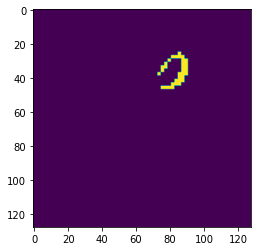

In [111]:
plt.imshow(mask[..., 26])

## Crop images in 3D rectangle where pixels > 0

In [21]:
path_data = os.path.join(os.getcwd(), '..', 'data')
path_segmentation = os.path.join(path_data, 'segmentation_xyz')
path_cropped = os.path.join(path_data, 'segmentation_xyz_cropped')

if not os.path.isdir(path_cropped):
    os.mkdir(path_cropped)
    

segmentations = list(df.loc[(df['mask'].isnull()), ['image']].to_records(index=False))
segmentations = list(map(
    lambda x: os.path.join(path_segmentation, x[0]), 
    segmentations
))

for file_path in tqdm(segmentations):
    
    file_name = file_path.split(os.sep)[-1]
    volume, _ = nrrd.read(file_path)
    
    indices = np.argwhere(volume > 0)
    
    idx_start_x, idx_start_y, idx_start_z = indices.argmin(axis=0)

    start_x = indices[idx_start_x][0]
    start_y = indices[idx_start_y][1]
    start_z = indices[idx_start_z][2]
        
    idx_end_x, idx_end_y, idx_end_z = indices.argmax(axis=0)

    end_x = indices[idx_end_x][0]
    end_y = indices[idx_end_y][1]
    end_z = indices[idx_end_z][2]
    
    cropped_volume = volume[start_x: end_x, start_y: end_y, start_z: end_z]
    cropped_volume = np.expand_dims(cropped_volume, axis=0)
    
    resize = tio.Resize((128, 128, cropped_volume.shape[-1]), image_interpolation='linear')
    resized_volume = np.squeeze(resize(cropped_volume), axis=0)
    
    nrrd.write(os.path.join(path_cropped, file_name), resized_volume)

  0%|          | 0/92 [00:00<?, ?it/s]